In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [2]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

labels[55][labels[55]:eq(0)] = 8
-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = {}
std = {}

for channel = 1,3 do
    mean[channel] = images[{{}, channel, {}, {}}]:mean()
    images[{{}, channel, {}, {}}]:add(-mean[channel])
    
    std[channel] = images[{{}, channel, {}, {}}]:std()
    images[{{}, channel, {}, {}}]:div(std[channel])
end

collectgarbage()

### Render labels for displaying

In [3]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
--             if not LUT[labels[{i,j}]] then
--                 print(labels[{i,j}], i, j)
--             end
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.62
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

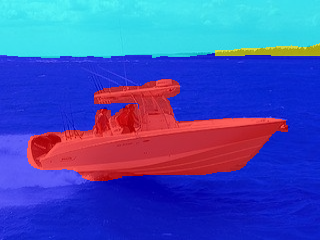

In [4]:
-- example blending
local k = 21
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

if CUDA then
    require 'cunn'
end

require 'nngraph'

In [8]:
-- testDir = 'SB overfit/window LR experiments, 2 layers, no constraints/x900/'

-- net = torch.load(testDir .. 'net.t7')
-- losses = torch.load(testDir .. 'loss-history.t7')
-- os.execute('mkdir "' .. testDir .. 'Images (test)" -p')

-- local ints = net:findModules('IntegralSmartNorm')
-- for i = 1,#ints do
--     ints[i].maxX = 1e6
--     ints[i].maxY = 1e6
-- end

In [9]:
-- graph version with conv1 to int2 connection
require 'nngraph'

collectgarbage()

inData = nn.Identity()()

int1 = IntegralSmartNorm(120, 240, 320)(inData) -- 3 -> 360
conv1 = nn.SpatialConvolution(3, 14, 3,3, 1,1, 1,1)(inData) -- 3 -> 14
haar1 = nn.SpatialConvolutionMM(360+14, 10, 1,1,1,1)
    (nn.JoinTable(1,3)({int1, conv1})) -- 360+14 -> 10

int2 = IntegralSmartNorm(35, 240, 320)(nn.LeakyReLU(0.015)(haar1)) -- 10 -> 350
conv2 = nn.SpatialConvolutionMM(14, 14, 3,3, 1,1, 1,1)(nn.LeakyReLU(0.015)(conv1)) -- 14 -> 14
haar2 = nn.SpatialConvolutionMM(350+14, 10, 1,1,1,1)
    (nn.JoinTable(1,3)({int2, conv2})) -- 350+14 -> 10

int3 = IntegralSmartNorm(35, 240, 320)(nn.LeakyReLU(0.015)(haar2)) -- 10 -> 350
conv3 = nn.SpatialConvolutionMM(14, 14, 3,3, 1,1, 1,1)(nn.LeakyReLU(0.015)(conv2)) -- 14 -> 14

nin1 = nn.SpatialConvolutionMM(350+14, 32, 1,1,1,1)
    (nn.JoinTable(1,3)({int3, conv3})) -- 350+14 -> 32
nin2 = nn.SpatialConvolutionMM(32, 8, 1,1,1,1)
    (nn.LeakyReLU(0.015)(nin1)) -- 32 -> 8

reshape = nn.Reshape(8, 240*320)(nin2)
transpose = nn.Transpose({2, 1})(reshape)

net = nn.gModule({inData}, {transpose})

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 115
    ints[i].maxY = 140
end

int1.data.module.gradInput = nil
conv1.data.module.gradInput = nil
conv1.data.module.updateGradInput = function(self) return torch.CudaTensor() end

if CUDA then
    require 'cunn'
    net:cuda()
end

In [8]:
outputDir = 'SB segmentation/14 graph 3 layers/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [9]:
net = torch.load(outputDir .. 'net.t7')
ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 115
    ints[i].maxY = 140
end

ints[1].gradInput = nil
conv1 = net.innode.children[1].children[1].data.module
assert(torch.isTypeOf(conv1, nn.SpatialConvolution) or torch.isTypeOf(conv1, nn.SpatialConvolutionMM))
conv1.gradInput = nil
-- conv1.updateGradInput = function() return torch.Tensor():typeAs(conv1) end

-- net:cuda()

losses = torch.load(outputDir .. 'loss-history.t7')

In [3]:
torch.manualSeed(666)
cutorch.manualSeed(666)

params, gradParams = net:parameters()

In [14]:
losses = {}

In [5]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net.modules[1]:type())

In [28]:
sbInput = images[1]:cuda()
net:forward(sbInput)
-- int:updateGradInput(sbInput, sbGO)
-- int:accGradParameters(sbInput, sbGO, 1)
cutorch.synchronize()

local repeats = 50
times = torch.FloatTensor(repeats)

local timer = torch.Timer()
for k = 1,repeats do
--     int._backwardDone = false
    
--     int:updateGradInput(sbInput, sbGO)
--     int:accGradParameters(sbInput, sbGO, 1)
    net:forward(sbInput)

end

    cutorch.synchronize()
    
    print(timer:time().real /repeats)

-- print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.13852739810944	


In [6]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 0.23e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 440
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.73,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.00015
    }
end

In [22]:
for i = 1,#params do
    local lr = 0.1e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 440
    end
    
    optimStates[i].learningRate = lr
    optimStates[i].learningRateDecay = 0.0001
    optimStates[i].t = 1
end

In [7]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

-- windowDebugger_1:load(outputDir .. 'wd1.t7')
-- windowDebugger_2:load(outputDir .. 'wd2.t7')
-- windowDebugger_3:load(outputDir .. 'wd3.t7')

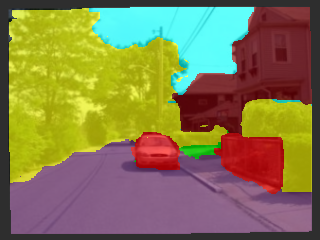

In [14]:
k = 13
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [8]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1000)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0., 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [9]:
plotLosses(losses)

In [10]:
function predict(net, example)
    local pred = net:forward(example:type(net.modules[1]:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [11]:
evaluationIdx = {
    26,13,58,74,89,98,103,110,132,127,630, -- buildings
    30,21,31,64,71,88,681, -- water/sand
    12,91,678,693, -- mountain
    3,59,82,118,120,698,650 -- grass/trees
}

table.sort(evaluationIdx)

In [12]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net.modules[1]:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(240, 320, 8):max(3)):squeeze():float()))
        end
        
        target = target:view(240*320)

        for i = 1,target:nElement() do
            if target[i] == 0 then
                target[i] = 3
                outputs[i]:zero()
                outputs[{i,3}] = 1e4
            end
        end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

## Training loop

In [15]:
batchSize = 10
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 10 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 5 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 100 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,10001 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(ints[1])
    windowDebugger_2:add(ints[2])
    windowDebugger_3:add(ints[3])
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
        windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]
                --torch.random() % 2 == 0)
            
            if torch.random() % 2 == 0 then
                input = image.flip(input, 3)
                target = image.flip(target, 2)
            else
                target = target:clone()
            end
            
            target = target:view(240*320)
            
            input = input:type(net.modules[1]:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net.modules[1]:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if iter % 5 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 5 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

windowDebugger_1:save('wd1.t7')
windowDebugger_2:save('wd2.t7')
windowDebugger_3:save('wd3.t7')

Epoch 0	


Iteration 5, loss = 0.48996168673038, Fri May 12 01:29:46 2017	


Iteration 10, loss = 0.44764059364796, Fri May 12 01:31:01 2017	


Iteration 15, loss = 0.49330691814423, Fri May 12 01:32:21 2017	


Iteration 20, loss = 0.48522288128734, Fri May 12 01:33:36 2017	


Iteration 25, loss = 0.45362382486463, Fri May 12 01:34:56 2017	


Iteration 30, loss = 0.4564595708251, Fri May 12 01:36:11 2017	


Iteration 35, loss = 0.49490475803614, Fri May 12 01:37:32 2017	


Iteration 40, loss = 0.50592625021935, Fri May 12 01:38:46 2017	


Iteration 45, loss = 0.43288233548403, Fri May 12 01:40:06 2017	


Iteration 50, loss = 0.49467548519373, Fri May 12 01:41:21 2017	


Iteration 55, loss = 0.48736464515328, Fri May 12 01:43:00 2017	


Iteration 60, loss = 0.52936424598098, Fri May 12 01:44:14 2017	


Iteration 65, loss = 0.40141357496381, Fri May 12 01:45:35 2017	


Iteration 70, loss = 0.49494189172983, Fri May 12 01:46:50 2017	


Epoch 1	


Iteration 75, loss = 0.49307301729918, Fri May 12 01:48:11 2017	


Iteration 80, loss = 0.51600229799747, Fri May 12 01:49:26 2017	


Iteration 85, loss = 0.50044823378325, Fri May 12 01:50:46 2017	


Iteration 90, loss = 0.42039794921875, Fri May 12 01:52:01 2017	


Iteration 95, loss = 0.48438594892621, Fri May 12 01:53:21 2017	


Iteration 100, loss = 0.43184132128954, Fri May 12 01:54:36 2017	


Iteration 105, loss = 0.55190034478903, Fri May 12 01:56:44 2017	


Iteration 110, loss = 0.46767917752266, Fri May 12 01:57:59 2017	


Iteration 115, loss = 0.4543365624547, Fri May 12 01:59:19 2017	


Iteration 120, loss = 0.4674568760395, Fri May 12 02:00:34 2017	


Iteration 125, loss = 0.47022800862789, Fri May 12 02:01:54 2017	


Iteration 130, loss = 0.46931214094162, Fri May 12 02:03:09 2017	


Iteration 135, loss = 0.42648252770305, Fri May 12 02:04:29 2017	


Iteration 140, loss = 0.44630128860474, Fri May 12 02:05:44 2017	


Epoch 2	


Iteration 145, loss = 0.50456235438585, Fri May 12 02:07:04 2017	


Iteration 150, loss = 0.45145128548145, Fri May 12 02:08:18 2017	


Iteration 155, loss = 0.44343679234385, Fri May 12 02:09:58 2017	


Iteration 160, loss = 0.46973546117544, Fri May 12 02:11:13 2017	


Iteration 165, loss = 0.47632113292813, Fri May 12 02:12:34 2017	


Iteration 170, loss = 0.50713940739632, Fri May 12 02:13:49 2017	


Iteration 175, loss = 0.50260310709476, Fri May 12 02:15:10 2017	


Iteration 180, loss = 0.45319150671363, Fri May 12 02:16:25 2017	


Iteration 185, loss = 0.47715435624123, Fri May 12 02:17:46 2017	


Iteration 190, loss = 0.47546956956387, Fri May 12 02:19:01 2017	


Iteration 195, loss = 0.47754349857569, Fri May 12 02:20:22 2017	


Iteration 200, loss = 0.48744991585612, Fri May 12 02:21:37 2017	


Iteration 205, loss = 0.47693292662501, Fri May 12 02:23:59 2017	


Iteration 210, loss = 0.49211942076683, Fri May 12 02:25:13 2017	


Iteration 215, loss = 0.45867734640837, Fri May 12 02:26:33 2017	


Epoch 3	


Iteration 220, loss = 0.47059214070439, Fri May 12 02:27:48 2017	


Iteration 225, loss = 0.46863394111395, Fri May 12 02:29:08 2017	


Iteration 230, loss = 0.45051376670599, Fri May 12 02:30:22 2017	


Iteration 235, loss = 0.43085757017136, Fri May 12 02:31:43 2017	


Iteration 240, loss = 0.48517046064138, Fri May 12 02:32:59 2017	


Iteration 245, loss = 0.44270159527659, Fri May 12 02:34:20 2017	


Iteration 250, loss = 0.43893520310521, Fri May 12 02:35:35 2017	


Iteration 255, loss = 0.47788074612617, Fri May 12 02:37:15 2017	


Iteration 260, loss = 0.47500650122762, Fri May 12 02:38:30 2017	


Iteration 265, loss = 0.4499100010097, Fri May 12 02:39:51 2017	


Iteration 270, loss = 0.58274780780077, Fri May 12 02:41:05 2017	


Iteration 275, loss = 0.45290806680918, Fri May 12 02:42:25 2017	


Iteration 280, loss = 0.4700850251317, Fri May 12 02:43:40 2017	


Iteration 285, loss = 0.51477394759655, Fri May 12 02:45:00 2017	


Epoch 4	


Iteration 290, loss = 0.46922018706799, Fri May 12 02:46:14 2017	


Iteration 295, loss = 0.43745546847582, Fri May 12 02:47:35 2017	


Iteration 300, loss = 0.44854975163937, Fri May 12 02:48:50 2017	


Iteration 305, loss = 0.53732646733522, Fri May 12 02:51:00 2017	


Iteration 310, loss = 0.45577888607979, Fri May 12 02:52:15 2017	


Iteration 315, loss = 0.49397265344858, Fri May 12 02:53:36 2017	


Iteration 320, loss = 0.50721073538065, Fri May 12 02:54:50 2017	


Iteration 325, loss = 0.49575485780835, Fri May 12 02:56:11 2017	


Iteration 330, loss = 0.49658449351788, Fri May 12 02:57:26 2017	


Iteration 335, loss = 0.46508309826255, Fri May 12 02:58:46 2017	


Iteration 340, loss = 0.42933667302132, Fri May 12 03:00:02 2017	


Iteration 345, loss = 0.46390016302466, Fri May 12 03:01:22 2017	


Iteration 350, loss = 0.44554514437914, Fri May 12 03:02:36 2017	


Iteration 355, loss = 0.42554230347276, Fri May 12 03:04:16 2017	


Iteration 360, loss = 0.51461646586657, Fri May 12 03:05:30 2017	
Epoch 5	


Iteration 365, loss = 0.43998082011938, Fri May 12 03:06:51 2017	


Iteration 370, loss = 0.43958723649383, Fri May 12 03:08:05 2017	


Iteration 375, loss = 0.51889707192779, Fri May 12 03:09:26 2017	


Iteration 380, loss = 0.44436025127769, Fri May 12 03:10:40 2017	


Iteration 385, loss = 0.4737085172534, Fri May 12 03:12:01 2017	


Iteration 390, loss = 0.46881849989295, Fri May 12 03:13:15 2017	


Iteration 395, loss = 0.42398437157273, Fri May 12 03:14:35 2017	


Iteration 400, loss = 0.5023257380724, Fri May 12 03:15:50 2017	


Iteration 405, loss = 0.46995041653514, Fri May 12 03:18:14 2017	


Iteration 410, loss = 0.47187287002802, Fri May 12 03:19:29 2017	


Iteration 415, loss = 0.4906260111928, Fri May 12 03:20:49 2017	


Iteration 420, loss = 0.50162053704262, Fri May 12 03:22:04 2017	


Iteration 425, loss = 0.48991227596998, Fri May 12 03:23:24 2017	


Iteration 430, loss = 0.5019086894393, Fri May 12 03:24:38 2017	


Epoch 6	


Iteration 435, loss = 0.46236343950033, Fri May 12 03:25:58 2017	


Iteration 440, loss = 0.43087896108627, Fri May 12 03:27:13 2017	


Iteration 445, loss = 0.47177840411663, Fri May 12 03:28:33 2017	


Iteration 450, loss = 0.5050343900919, Fri May 12 03:29:48 2017	


Iteration 455, loss = 0.43645439639688, Fri May 12 03:31:29 2017	


Iteration 460, loss = 0.43131011486053, Fri May 12 03:32:45 2017	


Iteration 465, loss = 0.51460857093334, Fri May 12 03:34:07 2017	


Iteration 470, loss = 0.47197387784719, Fri May 12 03:35:22 2017	


Iteration 475, loss = 0.46755589276552, Fri May 12 03:36:43 2017	


Iteration 480, loss = 0.46862955152988, Fri May 12 03:37:57 2017	


Iteration 485, loss = 0.51740287899971, Fri May 12 03:39:18 2017	


Iteration 490, loss = 0.50034745842218, Fri May 12 03:40:32 2017	


Iteration 495, loss = 0.46372959986329, Fri May 12 03:41:53 2017	


Iteration 500, loss = 0.47544855296612, Fri May 12 03:43:08 2017	


Epoch 7	


Iteration 505, loss = 0.48107610076666, Fri May 12 03:45:19 2017	


Iteration 510, loss = 0.4955661034584, Fri May 12 03:46:33 2017	


Iteration 515, loss = 0.45659998729825, Fri May 12 03:47:54 2017	


Iteration 520, loss = 0.51330352693796, Fri May 12 03:49:08 2017	


Iteration 525, loss = 0.45232927873731, Fri May 12 03:50:28 2017	


Iteration 530, loss = 0.48713104888797, Fri May 12 03:51:43 2017	


Iteration 535, loss = 0.49095835715532, Fri May 12 03:53:03 2017	


Iteration 540, loss = 0.42092925593257, Fri May 12 03:54:17 2017	


Iteration 545, loss = 0.41978658601642, Fri May 12 03:55:38 2017	


Iteration 550, loss = 0.44142842769623, Fri May 12 03:56:52 2017	


Iteration 555, loss = 0.47150495573878, Fri May 12 03:58:32 2017	


Iteration 560, loss = 0.47754049494863, Fri May 12 03:59:47 2017	


Iteration 565, loss = 0.50058580324054, Fri May 12 04:01:07 2017	


Iteration 570, loss = 0.43445499554276, Fri May 12 04:02:22 2017	


Iteration 575, loss = 0.52714658498764, Fri May 12 04:03:43 2017	


Epoch 8	


Iteration 580, loss = 0.47838029980659, Fri May 12 04:04:57 2017	


Iteration 585, loss = 0.44066199615598, Fri May 12 04:06:17 2017	


Iteration 590, loss = 0.45763115331531, Fri May 12 04:07:32 2017	


Iteration 595, loss = 0.51421591460705, Fri May 12 04:08:53 2017	


Iteration 600, loss = 0.44319802463055, Fri May 12 04:10:07 2017	


Iteration 605, loss = 0.43929051309824, Fri May 12 04:12:31 2017	


Iteration 610, loss = 0.53073847740889, Fri May 12 04:13:47 2017	


Iteration 615, loss = 0.47983177304268, Fri May 12 04:15:07 2017	


Iteration 620, loss = 0.45826956555247, Fri May 12 04:16:21 2017	


Iteration 625, loss = 0.50721560850739, Fri May 12 04:17:42 2017	


Iteration 630, loss = 0.49381916552782, Fri May 12 04:18:57 2017	


Iteration 635, loss = 0.42019004285336, Fri May 12 04:20:17 2017	


Iteration 640, loss = 0.50647346258163, Fri May 12 04:21:32 2017	


Iteration 645, loss = 0.48172747775912, Fri May 12 04:22:53 2017	


Epoch 9	


Iteration 650, loss = 0.4292586427927, Fri May 12 04:24:09 2017	


Iteration 655, loss = 0.50408890560269, Fri May 12 04:25:47 2017	


Iteration 660, loss = 0.39586349517107, Fri May 12 04:27:02 2017	


Iteration 665, loss = 0.476221473068, Fri May 12 04:28:22 2017	


Iteration 670, loss = 0.53035079419613, Fri May 12 04:29:36 2017	


Iteration 675, loss = 0.49677139475942, Fri May 12 04:30:56 2017	


Iteration 680, loss = 0.45143570542336, Fri May 12 04:32:11 2017	


Iteration 685, loss = 0.43431562900543, Fri May 12 04:33:31 2017	


Iteration 690, loss = 0.46732065856457, Fri May 12 04:34:46 2017	


Iteration 695, loss = 0.45347625032067, Fri May 12 04:36:06 2017	


Iteration 700, loss = 0.45653252139688, Fri May 12 04:37:21 2017	


Iteration 705, loss = 0.49859072253108, Fri May 12 04:39:36 2017	


Iteration 710, loss = 0.48249766021967, Fri May 12 04:40:50 2017	


Iteration 715, loss = 0.50588113993406, Fri May 12 04:42:12 2017	


Iteration 720, loss = 0.44589097887278, Fri May 12 04:43:27 2017	


Epoch 10	


Iteration 725, loss = 0.49237965077162, Fri May 12 04:44:48 2017	


Iteration 730, loss = 0.47428263917565, Fri May 12 04:46:02 2017	


Iteration 735, loss = 0.45625380992889, Fri May 12 04:47:23 2017	


Iteration 740, loss = 0.43282623052597, Fri May 12 04:48:39 2017	


Iteration 745, loss = 0.43591623842716, Fri May 12 04:50:00 2017	


Iteration 750, loss = 0.49977325871587, Fri May 12 04:51:14 2017	


Iteration 755, loss = 0.42439141079783, Fri May 12 04:52:54 2017	


Iteration 760, loss = 0.52777742177248, Fri May 12 04:54:09 2017	


Iteration 765, loss = 0.45490375623107, Fri May 12 04:55:30 2017	


Iteration 770, loss = 0.50030664920807, Fri May 12 04:56:45 2017	


Iteration 775, loss = 0.49229846328497, Fri May 12 04:58:06 2017	


Iteration 780, loss = 0.45202513694763, Fri May 12 04:59:21 2017	


Iteration 785, loss = 0.50889800786972, Fri May 12 05:00:42 2017	


Iteration 790, loss = 0.47961195081472, Fri May 12 05:01:57 2017	


Epoch 11	


Iteration 795, loss = 0.52423739269376, Fri May 12 05:03:17 2017	


Iteration 800, loss = 0.50258987516165, Fri May 12 05:04:32 2017	


Iteration 805, loss = 0.51252985835075, Fri May 12 05:07:04 2017	


Iteration 810, loss = 0.49872148841619, Fri May 12 05:08:19 2017	


Iteration 815, loss = 0.41527365595102, Fri May 12 05:09:39 2017	


Iteration 820, loss = 0.5173090967536, Fri May 12 05:10:53 2017	


Iteration 825, loss = 0.47212658569217, Fri May 12 05:12:14 2017	


Iteration 830, loss = 0.43431500628591, Fri May 12 05:13:28 2017	


Iteration 835, loss = 0.45495303720236, Fri May 12 05:14:49 2017	


Iteration 840, loss = 0.42974264398217, Fri May 12 05:16:04 2017	


Iteration 845, loss = 0.5148292902112, Fri May 12 05:17:24 2017	


Iteration 850, loss = 0.48250490397215, Fri May 12 05:18:39 2017	


Iteration 855, loss = 0.43937676757574, Fri May 12 05:20:18 2017	


Iteration 860, loss = 0.4658487868309, Fri May 12 05:21:33 2017	


Epoch 12	


Iteration 865, loss = 0.52433953672647, Fri May 12 05:22:54 2017	


Iteration 870, loss = 0.48825422659516, Fri May 12 05:24:10 2017	


Iteration 875, loss = 0.44755565822124, Fri May 12 05:25:31 2017	


Iteration 880, loss = 0.46918662816286, Fri May 12 05:26:48 2017	


Iteration 885, loss = 0.48845938578248, Fri May 12 05:28:09 2017	


Iteration 890, loss = 0.43637313008308, Fri May 12 05:29:26 2017	


Iteration 895, loss = 0.45090668275952, Fri May 12 05:30:48 2017	


Iteration 900, loss = 0.48786914944649, Fri May 12 05:32:04 2017	


Iteration 905, loss = 0.46120810776949, Fri May 12 05:34:18 2017	


Iteration 910, loss = 0.49255771428347, Fri May 12 05:35:33 2017	


Iteration 915, loss = 0.44887920171022, Fri May 12 05:36:53 2017	


Iteration 920, loss = 0.47902140259743, Fri May 12 05:38:08 2017	


Iteration 925, loss = 0.50415010541677, Fri May 12 05:39:29 2017	


Iteration 930, loss = 0.44145605742931, Fri May 12 05:40:44 2017	


Iteration 935, loss = 0.50845690816641, Fri May 12 05:42:04 2017	


Epoch 13	


Iteration 940, loss = 0.44933568447828, Fri May 12 05:43:19 2017	


Iteration 945, loss = 0.48184635490179, Fri May 12 05:44:39 2017	


Iteration 950, loss = 0.47956010431051, Fri May 12 05:45:54 2017	


Iteration 955, loss = 0.44974268123507, Fri May 12 05:47:34 2017	

Iteration 960, loss = 0.47780058801174, Fri May 12 05:48:49 2017	


Iteration 965, loss = 0.49544930398464, Fri May 12 05:50:13 2017	


Iteration 970, loss = 0.5090108114481, Fri May 12 05:51:31 2017	


Iteration 975, loss = 0.48961403310299, Fri May 12 05:52:54 2017	


Iteration 980, loss = 0.52095527082682, Fri May 12 05:54:13 2017	


Iteration 985, loss = 0.47772998183966, Fri May 12 05:55:38 2017	


Iteration 990, loss = 0.45787973731756, Fri May 12 05:56:57 2017	


Iteration 995, loss = 0.48118252664804, Fri May 12 05:58:21 2017	


Iteration 1000, loss = 0.49051498562098, Fri May 12 05:59:38 2017	


Iteration 1005, loss = 0.49231021299958, Fri May 12 06:01:58 2017	


Epoch 14	


Iteration 1010, loss = 0.41052479609847, Fri May 12 06:03:12 2017	


Iteration 1015, loss = 0.45160111427307, Fri May 12 06:04:33 2017	


Iteration 1020, loss = 0.43350945487618, Fri May 12 06:05:47 2017	


Iteration 1025, loss = 0.44889384657145, Fri May 12 06:07:07 2017	


Iteration 1030, loss = 0.47623189046979, Fri May 12 06:08:22 2017	


Iteration 1035, loss = 0.46407736569643, Fri May 12 06:09:43 2017	


Iteration 1040, loss = 0.48406844943762, Fri May 12 06:10:58 2017	


Iteration 1045, loss = 0.47613908261061, Fri May 12 06:12:19 2017	


Iteration 1050, loss = 0.50600383967161, Fri May 12 06:13:33 2017	


Iteration 1055, loss = 0.44242747977376, Fri May 12 06:15:11 2017	


Iteration 1060, loss = 0.50377015203238, Fri May 12 06:16:26 2017	


Iteration 1065, loss = 0.4893043422699, Fri May 12 06:17:46 2017	


Iteration 1070, loss = 0.51310712069273, Fri May 12 06:19:00 2017	


Iteration 1075, loss = 0.51536840617657, Fri May 12 06:20:21 2017	


Iteration 1080, loss = 0.47069003209472, Fri May 12 06:21:36 2017	
Epoch 15	


Iteration 1085, loss = 0.51305703520775, Fri May 12 06:22:56 2017	


Iteration 1090, loss = 0.4939332203567, Fri May 12 06:24:11 2017	


Iteration 1095, loss = 0.50982297837734, Fri May 12 06:25:31 2017	


Iteration 1100, loss = 0.50623527735472, Fri May 12 06:26:46 2017	


Iteration 1105, loss = 0.46316941127181, Fri May 12 06:29:05 2017	


Iteration 1110, loss = 0.45463026195765, Fri May 12 06:30:20 2017	


Iteration 1115, loss = 0.48251010492444, Fri May 12 06:31:40 2017	


Iteration 1120, loss = 0.48384708970785, Fri May 12 06:32:55 2017	


Iteration 1125, loss = 0.44466229915619, Fri May 12 06:34:15 2017	


Iteration 1130, loss = 0.43881950438023, Fri May 12 06:35:30 2017	


Iteration 1135, loss = 0.50972622424364, Fri May 12 06:36:50 2017	


Iteration 1140, loss = 0.47378606021404, Fri May 12 06:38:06 2017	


Iteration 1145, loss = 0.43253451228142, Fri May 12 06:39:26 2017	


Iteration 1150, loss = 0.4459181022644, Fri May 12 06:40:41 2017	


Epoch 16	


Iteration 1155, loss = 0.45411549419165, Fri May 12 06:42:20 2017	


Iteration 1160, loss = 0.5033213429153, Fri May 12 06:43:37 2017	


Iteration 1165, loss = 0.4679956972599, Fri May 12 06:45:00 2017	


Iteration 1170, loss = 0.46787412762642, Fri May 12 06:46:15 2017	


Iteration 1175, loss = 0.45897207915783, Fri May 12 06:47:36 2017	


Iteration 1180, loss = 0.44588103979826, Fri May 12 06:48:50 2017	


Iteration 1185, loss = 0.46864443987608, Fri May 12 06:50:11 2017	


Iteration 1190, loss = 0.51508813083172, Fri May 12 06:51:25 2017	


Iteration 1195, loss = 0.45526524335146, Fri May 12 06:52:45 2017	


Iteration 1200, loss = 0.4773065507412, Fri May 12 06:54:02 2017	


Iteration 1205, loss = 0.48708969563246, Fri May 12 06:56:23 2017	


Iteration 1210, loss = 0.47603640884161, Fri May 12 06:57:37 2017	


Iteration 1215, loss = 0.46242357313633, Fri May 12 06:58:57 2017	


Iteration 1220, loss = 0.50265623688698, Fri May 12 07:00:12 2017	


Epoch 17	


Iteration 1225, loss = 0.44888002425432, Fri May 12 07:01:32 2017	


Iteration 1230, loss = 0.4469904217124, Fri May 12 07:02:46 2017	


Iteration 1235, loss = 0.5175423553586, Fri May 12 07:04:07 2017	


Iteration 1240, loss = 0.46582460418344, Fri May 12 07:05:22 2017	


Iteration 1245, loss = 0.47636837899685, Fri May 12 07:06:42 2017	


Iteration 1250, loss = 0.49224137455225, Fri May 12 07:07:57 2017	


Iteration 1255, loss = 0.50965387165546, Fri May 12 07:09:36 2017	


Iteration 1260, loss = 0.49782712861896, Fri May 12 07:10:50 2017	


Iteration 1265, loss = 0.42357880532742, Fri May 12 07:12:11 2017	


Iteration 1270, loss = 0.50063499629498, Fri May 12 07:13:26 2017	


Iteration 1275, loss = 0.44045025885105, Fri May 12 07:14:46 2017	


Iteration 1280, loss = 0.43761206924915, Fri May 12 07:16:01 2017	


Iteration 1285, loss = 0.42702152311802, Fri May 12 07:17:21 2017	


Iteration 1290, loss = 0.48736234396696, Fri May 12 07:18:36 2017	


Iteration 1295, loss = 0.51015826255083, Fri May 12 07:19:56 2017	


Epoch 18	


Iteration 1300, loss = 0.44394163042307, Fri May 12 07:21:11 2017	


Iteration 1305, loss = 0.49154265835881, Fri May 12 07:23:34 2017	


Iteration 1310, loss = 0.48996702387929, Fri May 12 07:24:48 2017	


Iteration 1315, loss = 0.50508348986506, Fri May 12 07:26:08 2017	


Iteration 1320, loss = 0.45643251121044, Fri May 12 07:27:23 2017	


Iteration 1325, loss = 0.49937219411135, Fri May 12 07:28:43 2017	


Iteration 1330, loss = 0.48618689775467, Fri May 12 07:29:58 2017	


Iteration 1335, loss = 0.46698841482401, Fri May 12 07:31:18 2017	


Iteration 1340, loss = 0.47294723898172, Fri May 12 07:32:32 2017	


Iteration 1345, loss = 0.48151138141751, Fri May 12 07:33:52 2017	


Iteration 1350, loss = 0.42989613205194, Fri May 12 07:35:07 2017	


Iteration 1355, loss = 0.48006828546524, Fri May 12 07:36:46 2017	


Iteration 1360, loss = 0.47678260311484, Fri May 12 07:38:01 2017	


Iteration 1365, loss = 0.4542276468873, Fri May 12 07:39:21 2017	


Epoch 19	


Iteration 1370, loss = 0.50906622767448, Fri May 12 07:40:35 2017	


Iteration 1375, loss = 0.46533412665129, Fri May 12 07:41:55 2017	


Iteration 1380, loss = 0.44362546831369, Fri May 12 07:43:10 2017	


Iteration 1385, loss = 0.45467588156462, Fri May 12 07:44:31 2017	


Iteration 1390, loss = 0.4723083370924, Fri May 12 07:45:45 2017	


Iteration 1395, loss = 0.4561371076107, Fri May 12 07:47:05 2017	


Iteration 1400, loss = 0.43482234597206, Fri May 12 07:48:23 2017	


Iteration 1405, loss = 0.50991817742586, Fri May 12 07:50:46 2017	


Iteration 1410, loss = 0.51644434928894, Fri May 12 07:52:01 2017	


Iteration 1415, loss = 0.49292797252536, Fri May 12 07:53:23 2017	


Iteration 1420, loss = 0.49339623257518, Fri May 12 07:54:39 2017	


Iteration 1425, loss = 0.44379017651081, Fri May 12 07:56:00 2017	


Iteration 1430, loss = 0.45597937643528, Fri May 12 07:57:14 2017	


Iteration 1435, loss = 0.48293636113405, Fri May 12 07:58:34 2017	


Iteration 1440, loss = 0.52980368688703, Fri May 12 07:59:49 2017	
Epoch 20	


Iteration 1445, loss = 0.52294071033597, Fri May 12 08:01:10 2017	


Iteration 1450, loss = 0.46321833044291, Fri May 12 08:02:25 2017	


Iteration 1455, loss = 0.47262697026134, Fri May 12 08:04:04 2017	


Iteration 1460, loss = 0.45624888435006, Fri May 12 08:05:20 2017	


Iteration 1465, loss = 0.50051210150123, Fri May 12 08:06:40 2017	


Iteration 1470, loss = 0.46766156464815, Fri May 12 08:07:56 2017	


Iteration 1475, loss = 0.46079172238708, Fri May 12 08:09:17 2017	


Iteration 1480, loss = 0.4083828920126, Fri May 12 08:10:32 2017	


Iteration 1485, loss = 0.46773913010955, Fri May 12 08:11:53 2017	


Iteration 1490, loss = 0.4614991979301, Fri May 12 08:13:09 2017	


Iteration 1495, loss = 0.46618686974049, Fri May 12 08:14:30 2017	


Iteration 1500, loss = 0.50226956039667, Fri May 12 08:15:45 2017	


Iteration 1505, loss = 0.48739044010639, Fri May 12 08:18:07 2017	


Iteration 1510, loss = 0.48216000676155, Fri May 12 08:19:21 2017	


Epoch 21	


Iteration 1515, loss = 0.43939529165626, Fri May 12 08:20:42 2017	


Iteration 1520, loss = 0.50336426645517, Fri May 12 08:21:57 2017	


Iteration 1525, loss = 0.43342684388161, Fri May 12 08:23:19 2017	


Iteration 1530, loss = 0.48026735454798, Fri May 12 08:24:36 2017	


Iteration 1535, loss = 0.48668420672417, Fri May 12 08:25:58 2017	


Iteration 1540, loss = 0.47516909986734, Fri May 12 08:27:15 2017	


Iteration 1545, loss = 0.4586760365963, Fri May 12 08:28:37 2017	


Iteration 1550, loss = 0.50495499044657, Fri May 12 08:29:53 2017	


Iteration 1555, loss = 0.45024870350957, Fri May 12 08:31:30 2017	


Iteration 1560, loss = 0.47964677602053, Fri May 12 08:32:45 2017	


Iteration 1565, loss = 0.46742500245571, Fri May 12 08:34:05 2017	


Iteration 1570, loss = 0.47182896435261, Fri May 12 08:35:20 2017	


Iteration 1575, loss = 0.477593947649, Fri May 12 08:36:40 2017	


Iteration 1580, loss = 0.498065777421, Fri May 12 08:37:55 2017	


Epoch 22	


Iteration 1585, loss = 0.49624717846513, Fri May 12 08:39:16 2017	


Iteration 1590, loss = 0.48066870898008, Fri May 12 08:40:30 2017	


Iteration 1595, loss = 0.50194013535976, Fri May 12 08:41:50 2017	


Iteration 1600, loss = 0.42084599629045, Fri May 12 08:43:09 2017	


Iteration 1605, loss = 0.49418869793415, Fri May 12 08:45:30 2017	


Iteration 1610, loss = 0.48340444892645, Fri May 12 08:46:46 2017	


Iteration 1615, loss = 0.42915736064315, Fri May 12 08:48:08 2017	


Iteration 1620, loss = 0.46852159425616, Fri May 12 08:49:23 2017	


Iteration 1625, loss = 0.48679116979241, Fri May 12 08:50:45 2017	


Iteration 1630, loss = 0.46442042201757, Fri May 12 08:52:01 2017	


Iteration 1635, loss = 0.48021842628717, Fri May 12 08:53:23 2017	


Iteration 1640, loss = 0.48076000958681, Fri May 12 08:54:39 2017	


Iteration 1645, loss = 0.52269035696983, Fri May 12 08:56:00 2017	


Iteration 1650, loss = 0.49474076092243, Fri May 12 08:57:17 2017	


Iteration 1655, loss = 0.45385914802551, Fri May 12 08:58:55 2017	


Epoch 23	


Iteration 1660, loss = 0.51585390657187, Fri May 12 09:00:10 2017	


Iteration 1665, loss = 0.46121494710445, Fri May 12 09:01:30 2017	


Iteration 1670, loss = 0.41334608450532, Fri May 12 09:02:46 2017	


Iteration 1675, loss = 0.47331169560552, Fri May 12 09:04:08 2017	


Iteration 1680, loss = 0.47999436944723, Fri May 12 09:05:24 2017	


Iteration 1685, loss = 0.44176550447941, Fri May 12 09:06:45 2017	


Iteration 1690, loss = 0.48115548342466, Fri May 12 09:08:01 2017	


Iteration 1695, loss = 0.47607248052955, Fri May 12 09:09:23 2017	


Iteration 1700, loss = 0.53809205502272, Fri May 12 09:10:38 2017	


Iteration 1705, loss = 0.49072490513325, Fri May 12 09:13:01 2017	


Iteration 1710, loss = 0.45297394156456, Fri May 12 09:14:15 2017	


Iteration 1715, loss = 0.51371109068394, Fri May 12 09:15:35 2017	


Iteration 1720, loss = 0.49089986234903, Fri May 12 09:16:50 2017	


Iteration 1725, loss = 0.47525565773249, Fri May 12 09:18:10 2017	


Epoch 24	


Iteration 1730, loss = 0.4281500351429, Fri May 12 09:19:25 2017	


Iteration 1735, loss = 0.44571253269911, Fri May 12 09:20:46 2017	


Iteration 1740, loss = 0.45937706559896, Fri May 12 09:22:01 2017	


Iteration 1745, loss = 0.51010783538222, Fri May 12 09:23:24 2017	


Iteration 1750, loss = 0.50829542458057, Fri May 12 09:24:39 2017	


Iteration 1755, loss = 0.42640744879842, Fri May 12 09:26:16 2017	


Iteration 1760, loss = 0.42854757487774, Fri May 12 09:27:32 2017	


Iteration 1765, loss = 0.4955856475234, Fri May 12 09:28:52 2017	


Iteration 1770, loss = 0.48718684673309, Fri May 12 09:30:07 2017	


Iteration 1775, loss = 0.45803237915039, Fri May 12 09:31:27 2017	


Iteration 1780, loss = 0.45653878688812, Fri May 12 09:32:42 2017	


Iteration 1785, loss = 0.50236336737871, Fri May 12 09:34:02 2017	


Iteration 1790, loss = 0.49352311506867, Fri May 12 09:35:17 2017	


Iteration 1795, loss = 0.45238947674632, Fri May 12 09:36:40 2017	


Iteration 1800, loss = 0.51851779282093, Fri May 12 09:37:56 2017	
Epoch 25	


Iteration 1805, loss = 0.49165550559759, Fri May 12 09:40:22 2017	


Iteration 1810, loss = 0.47947803616524, Fri May 12 09:41:39 2017	


Iteration 1815, loss = 0.48897660717368, Fri May 12 09:42:59 2017	


Iteration 1820, loss = 0.47987623035908, Fri May 12 09:44:14 2017	


Iteration 1825, loss = 0.4562899902463, Fri May 12 09:45:35 2017	


Iteration 1830, loss = 0.49425061196089, Fri May 12 09:46:50 2017	


Iteration 1835, loss = 0.49697501197457, Fri May 12 09:48:12 2017	


Iteration 1840, loss = 0.43748876392841, Fri May 12 09:49:27 2017	


Iteration 1845, loss = 0.47643751740456, Fri May 12 09:50:49 2017	


Iteration 1850, loss = 0.4752957624197, Fri May 12 09:52:05 2017	


Iteration 1855, loss = 0.46719856321812, Fri May 12 09:53:42 2017	


Iteration 1860, loss = 0.45590644389391, Fri May 12 09:54:57 2017	


Iteration 1865, loss = 0.49775853961706, Fri May 12 09:56:17 2017	


Iteration 1870, loss = 0.44461775004864, Fri May 12 09:57:32 2017	


Epoch 26	


Iteration 1875, loss = 0.51856415435672, Fri May 12 09:58:53 2017	


Iteration 1880, loss = 0.47904550224543, Fri May 12 10:00:08 2017	


Iteration 1885, loss = 0.4698147764802, Fri May 12 10:01:30 2017	


Iteration 1890, loss = 0.469537435323, Fri May 12 10:02:45 2017	


Iteration 1895, loss = 0.50997568801045, Fri May 12 10:04:06 2017	


Iteration 1900, loss = 0.49799778133631, Fri May 12 10:05:22 2017	


Iteration 1905, loss = 0.48010949462652, Fri May 12 10:07:49 2017	


Iteration 1910, loss = 0.45199619546533, Fri May 12 10:09:05 2017	


Iteration 1915, loss = 0.48132125407457, Fri May 12 10:10:26 2017	


Iteration 1920, loss = 0.41399038717151, Fri May 12 10:11:43 2017	


Iteration 1925, loss = 0.46909831658006, Fri May 12 10:13:04 2017	


Iteration 1930, loss = 0.4625407859683, Fri May 12 10:14:20 2017	


Iteration 1935, loss = 0.44698965489864, Fri May 12 10:15:41 2017	


Iteration 1940, loss = 0.50425045609474, Fri May 12 10:16:57 2017	


Epoch 27	


Iteration 1945, loss = 0.43186238914728, Fri May 12 10:18:18 2017	


Iteration 1950, loss = 0.46843423247337, Fri May 12 10:19:34 2017	


Iteration 1955, loss = 0.45155242711306, Fri May 12 10:21:12 2017	


Iteration 1960, loss = 0.46236068233848, Fri May 12 10:22:27 2017	


Iteration 1965, loss = 0.50327185347676, Fri May 12 10:23:47 2017	


Iteration 1970, loss = 0.49038416430354, Fri May 12 10:25:02 2017	


Iteration 1975, loss = 0.4515571013093, Fri May 12 10:26:22 2017	


Iteration 1980, loss = 0.51507928818464, Fri May 12 10:27:37 2017	


Iteration 1985, loss = 0.43460761278868, Fri May 12 10:28:57 2017	


Iteration 1990, loss = 0.50033483445644, Fri May 12 10:30:12 2017	


Iteration 1995, loss = 0.45957993775606, Fri May 12 10:31:35 2017	


Iteration 2000, loss = 0.4723814162612, Fri May 12 10:32:50 2017	


Iteration 2005, loss = 0.50527074351907, Fri May 12 10:35:16 2017	


Iteration 2010, loss = 0.47153395682573, Fri May 12 10:36:30 2017	


Iteration 2015, loss = 0.46415502667427, Fri May 12 10:37:51 2017	


Epoch 28	


Iteration 2020, loss = 0.41526691839099, Fri May 12 10:39:06 2017	


Iteration 2025, loss = 0.4758682307601, Fri May 12 10:40:28 2017	


Iteration 2030, loss = 0.45322228506207, Fri May 12 10:41:44 2017	


Iteration 2035, loss = 0.47552513331175, Fri May 12 10:43:05 2017	


Iteration 2040, loss = 0.53440702229738, Fri May 12 10:44:20 2017	


Iteration 2045, loss = 0.40821444660425, Fri May 12 10:45:41 2017	


Iteration 2050, loss = 0.51918057411909, Fri May 12 10:47:00 2017	


Iteration 2055, loss = 0.47071139737964, Fri May 12 10:48:38 2017	


Iteration 2060, loss = 0.42914079010487, Fri May 12 10:49:52 2017	


Iteration 2065, loss = 0.47918052747846, Fri May 12 10:51:13 2017	


Iteration 2070, loss = 0.47707909792662, Fri May 12 10:52:27 2017	


Iteration 2075, loss = 0.44600190579891, Fri May 12 10:53:47 2017	


Iteration 2080, loss = 0.51252790600061, Fri May 12 10:55:02 2017	


Iteration 2085, loss = 0.52662160605192, Fri May 12 10:56:23 2017	


Epoch 29	


Iteration 2090, loss = 0.50813557207584, Fri May 12 10:57:38 2017	


Iteration 2095, loss = 0.47827905207872, Fri May 12 10:58:59 2017	


Iteration 2100, loss = 0.51886823683977, Fri May 12 11:00:14 2017	


Iteration 2105, loss = 0.44961369886994, Fri May 12 11:02:43 2017	


Iteration 2110, loss = 0.42916377440095, Fri May 12 11:03:58 2017	


Iteration 2115, loss = 0.46005083873868, Fri May 12 11:05:18 2017	


Iteration 2120, loss = 0.4830770303309, Fri May 12 11:06:33 2017	


Iteration 2125, loss = 0.47172685414553, Fri May 12 11:07:54 2017	


Iteration 2130, loss = 0.39916954889894, Fri May 12 11:09:09 2017	


Iteration 2135, loss = 0.50212501347065, Fri May 12 11:10:30 2017	


Iteration 2140, loss = 0.45444940209389, Fri May 12 11:11:45 2017	


Iteration 2145, loss = 0.49659688919783, Fri May 12 11:13:07 2017	


Iteration 2150, loss = 0.46903182297945, Fri May 12 11:14:23 2017	


Iteration 2155, loss = 0.51364586085081, Fri May 12 11:16:01 2017	


Iteration 2160, loss = 0.4881018987298, Fri May 12 11:17:16 2017	
Epoch 30	


Iteration 2165, loss = 0.4464909952879, Fri May 12 11:18:36 2017	


Iteration 2170, loss = 0.46126791939139, Fri May 12 11:19:51 2017	


Iteration 2175, loss = 0.49255232349038, Fri May 12 11:21:13 2017	


Iteration 2180, loss = 0.49223246455193, Fri May 12 11:22:28 2017	


Iteration 2185, loss = 0.51830289304256, Fri May 12 11:23:51 2017	


Iteration 2190, loss = 0.42814592376351, Fri May 12 11:25:07 2017	


Iteration 2195, loss = 0.47973177194595, Fri May 12 11:26:31 2017	


Iteration 2200, loss = 0.48365172162652, Fri May 12 11:27:46 2017	


Iteration 2205, loss = 0.47445380657911, Fri May 12 11:30:15 2017	


Iteration 2210, loss = 0.45102845102549, Fri May 12 11:31:30 2017	


Iteration 2215, loss = 0.49887403637171, Fri May 12 11:32:50 2017	


Iteration 2220, loss = 0.49290653169155, Fri May 12 11:34:05 2017	


Iteration 2225, loss = 0.45762775197625, Fri May 12 11:35:27 2017	


Iteration 2230, loss = 0.44871492594481, Fri May 12 11:36:45 2017	


Epoch 31	


Iteration 2235, loss = 0.46516534134746, Fri May 12 11:38:05 2017	


Iteration 2240, loss = 0.49633907109499, Fri May 12 11:39:20 2017	


Iteration 2245, loss = 0.42729793459177, Fri May 12 11:40:40 2017	


Iteration 2250, loss = 0.47481318026781, Fri May 12 11:41:56 2017	


Iteration 2255, loss = 0.46356783241034, Fri May 12 11:43:34 2017	


Iteration 2260, loss = 0.4682475399971, Fri May 12 11:44:48 2017	


Iteration 2265, loss = 0.46890252441168, Fri May 12 11:46:08 2017	


Iteration 2270, loss = 0.48487552583218, Fri May 12 11:47:23 2017	


Iteration 2275, loss = 0.50065004706383, Fri May 12 11:48:44 2017	


Iteration 2280, loss = 0.48862465798855, Fri May 12 11:50:01 2017	


Iteration 2285, loss = 0.51975895017385, Fri May 12 11:51:25 2017	


Iteration 2290, loss = 0.46583503052592, Fri May 12 11:52:43 2017	


Iteration 2295, loss = 0.43532488293946, Fri May 12 11:54:05 2017	


Iteration 2300, loss = 0.51563351333141, Fri May 12 11:55:20 2017	


Epoch 32	


Iteration 2305, loss = 0.44724540412426, Fri May 12 11:57:50 2017	


Iteration 2310, loss = 0.47437762528658, Fri May 12 11:59:05 2017	


Iteration 2315, loss = 0.47452559560537, Fri May 12 12:00:25 2017	


Iteration 2320, loss = 0.48073500573635, Fri May 12 12:01:41 2017	


Iteration 2325, loss = 0.45018639951944, Fri May 12 12:03:02 2017	


Iteration 2330, loss = 0.45871730148792, Fri May 12 12:04:17 2017	


Iteration 2335, loss = 0.49229591876268, Fri May 12 12:05:38 2017	


Iteration 2340, loss = 0.47528119832277, Fri May 12 12:06:53 2017	


Iteration 2345, loss = 0.53095553472638, Fri May 12 12:08:14 2017	


Iteration 2350, loss = 0.47313006997108, Fri May 12 12:09:30 2017	


Iteration 2355, loss = 0.48990784943104, Fri May 12 12:11:07 2017	


Iteration 2360, loss = 0.45894465655088, Fri May 12 12:12:22 2017	


Iteration 2365, loss = 0.49165675789118, Fri May 12 12:13:43 2017	


Iteration 2370, loss = 0.45939535990357, Fri May 12 12:15:00 2017	


Iteration 2375, loss = 0.47383510142565, Fri May 12 12:16:21 2017	


Epoch 33	


Iteration 2380, loss = 0.45119830816984, Fri May 12 12:17:38 2017	


Iteration 2385, loss = 0.52965054452419, Fri May 12 12:19:01 2017	


Iteration 2390, loss = 0.4778094291687, Fri May 12 12:20:19 2017	


Iteration 2395, loss = 0.47261855736375, Fri May 12 12:21:41 2017	


Iteration 2400, loss = 0.4610492965579, Fri May 12 12:22:58 2017	


Iteration 2405, loss = 0.44272380977869, Fri May 12 12:25:28 2017	


Iteration 2410, loss = 0.50920567855239, Fri May 12 12:26:43 2017	


Iteration 2415, loss = 0.46583992481232, Fri May 12 12:28:03 2017	


Iteration 2420, loss = 0.50769943475723, Fri May 12 12:29:18 2017	


Iteration 2425, loss = 0.4516420724988, Fri May 12 12:30:38 2017	


Iteration 2430, loss = 0.46468739748001, Fri May 12 12:31:53 2017	


Iteration 2435, loss = 0.45733378946781, Fri May 12 12:33:14 2017	


Iteration 2440, loss = 0.49074428588152, Fri May 12 12:34:30 2017	


Iteration 2445, loss = 0.48695092812181, Fri May 12 12:35:53 2017	


Epoch 34	


Iteration 2450, loss = 0.44731639623642, Fri May 12 12:37:09 2017	


Iteration 2455, loss = 0.47442602485418, Fri May 12 12:38:47 2017	


Iteration 2460, loss = 0.52207625448704, Fri May 12 12:40:02 2017	


Iteration 2465, loss = 0.44896940782666, Fri May 12 12:41:22 2017	


Iteration 2470, loss = 0.45935033977032, Fri May 12 12:42:36 2017	


Iteration 2475, loss = 0.47413538306952, Fri May 12 12:43:57 2017	


Iteration 2480, loss = 0.47259035602212, Fri May 12 12:45:12 2017	


Iteration 2485, loss = 0.45878622561693, Fri May 12 12:46:32 2017	


Iteration 2490, loss = 0.52524261295795, Fri May 12 12:47:48 2017	


Iteration 2495, loss = 0.48718159049749, Fri May 12 12:49:09 2017	


Iteration 2500, loss = 0.46847548007965, Fri May 12 12:50:24 2017	


Iteration 2505, loss = 0.45451300889254, Fri May 12 12:52:56 2017	


Iteration 2510, loss = 0.52828506946564, Fri May 12 12:54:11 2017	


Iteration 2515, loss = 0.46271513804793, Fri May 12 12:55:31 2017	


Iteration 2520, loss = 0.42788652837276, Fri May 12 12:56:46 2017	


Epoch 35	


Iteration 2525, loss = 0.5053140000999, Fri May 12 12:58:07 2017	


Iteration 2530, loss = 0.48627179965377, Fri May 12 12:59:21 2017	


Iteration 2535, loss = 0.44510409682989, Fri May 12 13:00:42 2017	


Iteration 2540, loss = 0.53678743302822, Fri May 12 13:01:58 2017	


Iteration 2545, loss = 0.43328444778919, Fri May 12 13:03:21 2017	


Iteration 2550, loss = 0.48966273978353, Fri May 12 13:04:36 2017	


Iteration 2555, loss = 0.45704279989004, Fri May 12 13:06:16 2017	


Iteration 2560, loss = 0.4778816151619, Fri May 12 13:07:35 2017	


Iteration 2565, loss = 0.48202310591936, Fri May 12 13:08:59 2017	


Iteration 2570, loss = 0.47314121454954, Fri May 12 13:10:19 2017	


Iteration 2575, loss = 0.45035416007042, Fri May 12 13:11:44 2017	


Iteration 2580, loss = 0.46763596311212, Fri May 12 13:13:03 2017	


Iteration 2585, loss = 0.50348959803581, Fri May 12 13:14:30 2017	


Iteration 2590, loss = 0.43999454170465, Fri May 12 13:15:45 2017	


Epoch 36	


Iteration 2595, loss = 0.47576293945312, Fri May 12 13:17:06 2017	


Iteration 2600, loss = 0.44512686833739, Fri May 12 13:18:20 2017	


Iteration 2605, loss = 0.47400433570147, Fri May 12 13:20:52 2017	


Iteration 2610, loss = 0.50728359267116, Fri May 12 13:22:07 2017	


Iteration 2615, loss = 0.44949400424957, Fri May 12 13:23:31 2017	


Iteration 2620, loss = 0.40239269629121, Fri May 12 13:24:50 2017	


Iteration 2625, loss = 0.509176658988, Fri May 12 13:26:14 2017	


Iteration 2630, loss = 0.47805811613798, Fri May 12 13:27:33 2017	


Iteration 2635, loss = 0.53339436352253, Fri May 12 13:28:56 2017	


Iteration 2640, loss = 0.46743908137083, Fri May 12 13:30:11 2017	


Iteration 2645, loss = 0.44707011193037, Fri May 12 13:31:31 2017	


Iteration 2650, loss = 0.48511876925826, Fri May 12 13:32:47 2017	


Iteration 2655, loss = 0.46029521346092, Fri May 12 13:34:24 2017	


Iteration 2660, loss = 0.51151978597045, Fri May 12 13:35:39 2017	


Epoch 37	


Iteration 2665, loss = 0.45010923117399, Fri May 12 13:37:00 2017	


Iteration 2670, loss = 0.42362375259399, Fri May 12 13:38:15 2017	


Iteration 2675, loss = 0.4837622115016, Fri May 12 13:39:35 2017	


Iteration 2680, loss = 0.49490998595953, Fri May 12 13:40:50 2017	


Iteration 2685, loss = 0.44679379031062, Fri May 12 13:42:12 2017	


Iteration 2690, loss = 0.48587483167648, Fri May 12 13:43:26 2017	


Iteration 2695, loss = 0.44965897858143, Fri May 12 13:44:47 2017	


Iteration 2700, loss = 0.53015302330256, Fri May 12 13:46:01 2017	


Iteration 2705, loss = 0.48962666600943, Fri May 12 13:48:34 2017	


Iteration 2710, loss = 0.47602256551385, Fri May 12 13:49:49 2017	


Iteration 2715, loss = 0.50186943113804, Fri May 12 13:51:09 2017	


Iteration 2720, loss = 0.47451332166791, Fri May 12 13:52:24 2017	


Iteration 2725, loss = 0.42883500427008, Fri May 12 13:53:45 2017	


Iteration 2730, loss = 0.47334601104259, Fri May 12 13:55:00 2017	


Iteration 2735, loss = 0.47807945251465, Fri May 12 13:56:21 2017	


Epoch 38	


Iteration 2740, loss = 0.45717147439718, Fri May 12 13:57:37 2017	


Iteration 2745, loss = 0.51722925722599, Fri May 12 13:58:58 2017	


Iteration 2750, loss = 0.49033341392875, Fri May 12 14:00:14 2017	


Iteration 2755, loss = 0.47419778101146, Fri May 12 14:01:52 2017	


Iteration 2760, loss = 0.46848841160536, Fri May 12 14:03:07 2017	


Iteration 2765, loss = 0.46601756602526, Fri May 12 14:04:27 2017	


Iteration 2770, loss = 0.4899761877954, Fri May 12 14:05:42 2017	


Iteration 2775, loss = 0.48589258000255, Fri May 12 14:07:02 2017	


Iteration 2780, loss = 0.48758760720491, Fri May 12 14:08:19 2017	


Iteration 2785, loss = 0.42603104323149, Fri May 12 14:09:42 2017	


Iteration 2790, loss = 0.45385879784822, Fri May 12 14:10:57 2017	


Iteration 2795, loss = 0.44495554178953, Fri May 12 14:12:18 2017	


Iteration 2800, loss = 0.48995818629861, Fri May 12 14:13:34 2017	


Iteration 2805, loss = 0.49244070440531, Fri May 12 14:16:10 2017	


Epoch 39	


Iteration 2810, loss = 0.4202282127738, Fri May 12 14:17:26 2017	


Iteration 2815, loss = 0.41740673899651, Fri May 12 14:18:47 2017	


Iteration 2820, loss = 0.54056505560875, Fri May 12 14:20:01 2017	


Iteration 2825, loss = 0.45016299396753, Fri May 12 14:21:22 2017	


Iteration 2830, loss = 0.53654299631715, Fri May 12 14:22:37 2017	


Iteration 2835, loss = 0.42133571520448, Fri May 12 14:23:58 2017	


Iteration 2840, loss = 0.4753154347837, Fri May 12 14:25:12 2017	


Iteration 2845, loss = 0.4808333773911, Fri May 12 14:26:33 2017	


Iteration 2850, loss = 0.49054905325174, Fri May 12 14:27:48 2017	


Iteration 2855, loss = 0.45860815376043, Fri May 12 14:29:27 2017	


Iteration 2860, loss = 0.44893541872501, Fri May 12 14:30:42 2017	


Iteration 2865, loss = 0.48110066309571, Fri May 12 14:32:03 2017	


Iteration 2870, loss = 0.46821029067039, Fri May 12 14:33:18 2017	


Iteration 2875, loss = 0.46912422657013, Fri May 12 14:34:39 2017	


Iteration 2880, loss = 0.4987710827589, Fri May 12 14:35:55 2017	
Epoch 40	


Iteration 2885, loss = 0.527455432266, Fri May 12 14:37:16 2017	

Iteration 2890, loss = 0.46134034514427, Fri May 12 14:38:31 2017	


Iteration 2895, loss = 0.52888941273093, Fri May 12 14:39:52 2017	


Iteration 2900, loss = 0.47134516388178, Fri May 12 14:41:08 2017	


Iteration 2905, loss = 0.49049230292439, Fri May 12 14:43:43 2017	


Iteration 2910, loss = 0.48247769832611, Fri May 12 14:44:58 2017	


Iteration 2915, loss = 0.46303984284401, Fri May 12 14:46:19 2017	


Iteration 2920, loss = 0.50773180142045, Fri May 12 14:47:33 2017	


Iteration 2925, loss = 0.44242072373629, Fri May 12 14:48:55 2017	


Iteration 2930, loss = 0.46485711187124, Fri May 12 14:50:13 2017	


Iteration 2935, loss = 0.50014659866691, Fri May 12 14:51:35 2017	


Iteration 2940, loss = 0.44047727704048, Fri May 12 14:52:51 2017	


Iteration 2945, loss = 0.46168318837881, Fri May 12 14:54:13 2017	


Iteration 2950, loss = 0.40934951752424, Fri May 12 14:55:29 2017	


Epoch 41	


Iteration 2955, loss = 0.48011120557785, Fri May 12 14:57:08 2017	


Iteration 2960, loss = 0.46583428278565, Fri May 12 14:58:23 2017	


Iteration 2965, loss = 0.48308082446456, Fri May 12 14:59:43 2017	


Iteration 2970, loss = 0.4706309530139, Fri May 12 15:00:58 2017	


Iteration 2975, loss = 0.48357657879591, Fri May 12 15:02:18 2017	


Iteration 2980, loss = 0.45612649485469, Fri May 12 15:03:38 2017	


Iteration 2985, loss = 0.46761086761951, Fri May 12 15:05:00 2017	


Iteration 2990, loss = 0.45622609838843, Fri May 12 15:06:16 2017	


Iteration 2995, loss = 0.50167153358459, Fri May 12 15:07:37 2017	


Iteration 3000, loss = 0.46926015377045, Fri May 12 15:08:52 2017	


Iteration 3005, loss = 0.42409963771701, Fri May 12 15:11:28 2017	


Iteration 3010, loss = 0.48129856616259, Fri May 12 15:12:44 2017	


Iteration 3015, loss = 0.48043048322201, Fri May 12 15:14:05 2017	


Iteration 3020, loss = 0.4973534847796, Fri May 12 15:15:22 2017	


Epoch 42	


Iteration 3025, loss = 0.51291394591331, Fri May 12 15:16:43 2017	


Iteration 3030, loss = 0.48264503717422, Fri May 12 15:17:59 2017	


Iteration 3035, loss = 0.49465147405863, Fri May 12 15:19:20 2017	


Iteration 3040, loss = 0.45057574599981, Fri May 12 15:20:36 2017	


Iteration 3045, loss = 0.46120063871145, Fri May 12 15:21:58 2017	


Iteration 3050, loss = 0.48982142239809, Fri May 12 15:23:14 2017	


Iteration 3055, loss = 0.45756921201944, Fri May 12 15:24:52 2017	


Iteration 3060, loss = 0.45921452224255, Fri May 12 15:26:07 2017	


Iteration 3065, loss = 0.46171272188425, Fri May 12 15:27:27 2017	


Iteration 3070, loss = 0.50186117440462, Fri May 12 15:28:42 2017	


Iteration 3075, loss = 0.47684868991375, Fri May 12 15:30:02 2017	


Iteration 3080, loss = 0.46212579995394, Fri May 12 15:31:18 2017	


Iteration 3085, loss = 0.43692809686065, Fri May 12 15:32:39 2017	


Iteration 3090, loss = 0.51163920789957, Fri May 12 15:33:54 2017	


Iteration 3095, loss = 0.480554613024, Fri May 12 15:35:15 2017	


Epoch 43	


Iteration 3100, loss = 0.45978999614716, Fri May 12 15:36:30 2017	


Iteration 3105, loss = 0.45295417830348, Fri May 12 15:39:09 2017	


## Display predictions for test samples

In [19]:
local filenames = {}
for file in paths.files(relative .. 'images_test/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'images_test/' .. filenames[i]), 320, 240, 'bicubic')
    
    local imgForNet = img:cuda()
    imgForNet:add(-mean)
    imgForNet:div(std)
    
    local prediction = predict(net, imgForNet)
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(testDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 1
end

collectgarbage()

In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}


## Overfit to small number of samples

In [33]:
outputDir = 'SB overfit/momentum, 2 layers, graph/666/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [34]:
torch.manualSeed(666)
cutorch.manualSeed(666)

net:reset()
params, gradParams = net:parameters()

losses = {}

In [35]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 11 and i <= 14) then
        lr = lr * 666 -- 2.5e3 -- lr * 400
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.999
    }
end

In [36]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

In [ ]:
idx = {55, 21, 26}
batchSize = #idx
shuffleEvery = 0 -- shuffle data every `shuffleEvery` iterations
outputFreq = 1 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 16 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 16 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

local avgLoss = 0

for iter = 1,999 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(int1.data.module)
    windowDebugger_2:add(int2.data.module)
    
    local batchLoss = 0 -- at current minibatch
    local outputs
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(int1.data.module:type())
            outputs = net:forward(input)
            
            if int1.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int1')
                batchLoss = 0/0
                break
            end
            
            if int2.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int2')
                batchLoss = 0/0
                break
            end
            
            if (iter-1) % (outputFreq * imgOutputFreq) == 0 then
                local outputImg = comparePredictions(images[idx[datasetIdx]], labels[idx[datasetIdx]], 
                            select(2, outputs:view(240, 320, 8):max(3)):squeeze():float())
                image.save(outputDir .. 'Images/' .. string.format('%03d.png', idx[datasetIdx]), outputImg)
            end

--             for i = 1,target:nElement() do
--                 if target[i] == 0 then
--                     target[i] = 3
--                     outputs[i]:zero()
--                     outputs[{i,3}] = 1e4
--                 end
--             end
            
            target = target:type(int1.data.module:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            
            if batchLoss ~= batchLoss then
                print('1st')
                break
            end
            
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            if int1.data.module.gradXMax[1] ~= int1.data.module.gradXMax[1] then
                print('2nd')
                batchLoss = 0/0
                break
            end
            
            datasetIdx = datasetIdx % #idx + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    if batchLoss ~= batchLoss then
        break
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 or #losses == 500 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
--         windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
        
        if #losses == 500 then break end
    end
    
    if iter % 4 == 0 then
        print('Iteration ' .. iter .. ', ' .. os.date())
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

In [ ]:
local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
target = target:view(240*320):typeAs(net)

-- probs = nn.SoftMax():typeAs(net):forward(net.output)
for k = 1,target:size(1) do
    local logloss = criterion:forward(net.output[k], target[k])
    if logloss ~= logloss then
        print(k)
--         break
    end
end